In [51]:
# Data
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.impute import  SimpleImputer #, KNNImputer
from sklearn.preprocessing import StandardScaler
# Plot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# ML
## Models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.svm import SVC
# cv
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Data preparation

In [68]:
churn = pd.read_csv(r"C:\Users\leoac\OneDrive\Work\Applications\xTream\xtream-ai-assignment\datasets\employee-churn\churn.csv")

Profiling

In [3]:
profile = ProfileReport(churn, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
churn.drop('city', axis=1, inplace=True)

In [5]:
# Correct the typo
churn.rename({'relevent_experience': 'relevant_experience'}, axis=1, inplace=True)
churn.relevant_experience = churn.relevant_experience.str.replace('relevent', 'relevant')

In [6]:
# Ordinal encoding for education_level
education_mapping = {
    'Primary School': 1,
    'High School': 2,
    'Graduate': 3,
    'Masters': 4,
    'Phd': 5
}
churn.education_level = churn.education_level.map(education_mapping)

In [7]:
# Interval encoding for experience
# Replace limit values and cast the column to float type
experience_replacements = {
    '>20': 20.5,
    '<1': 0.5
}
churn.experience = churn.experience.replace(experience_replacements).astype(float)
# Divide the column into intervals of experience years
churn.experience = pd.cut(x=churn.experience, bins=[0, 1, 5, 10, 20, 21], right=False, labels=['<1', '1-5', '6-10', '11-20', '>20'])

In [8]:
# Data format fixing for company_size
churn.company_size.replace({'10/49': '10-49', '10000+': '>10000'}, inplace=True)

In [9]:
# Drop the rows with NaNs in enrolled_university, education_level, experience, last_new_job (see NaN handling)
churn = churn[(churn.enrolled_university.isna() == False) & (churn.education_level.isna() == False) & (churn.experience.isna() == False) & (churn.last_new_job.isna() == False)].reset_index(drop=True)

In [10]:
churn.isna().sum()

enrollee_id                  0
city_development_index       0
gender                    3863
relevant_experience          0
enrolled_university          0
education_level              0
major_discipline          2222
experience                   0
company_size              5310
company_type              5476
last_new_job                 0
training_hours               0
target                       0
dtype: int64

Missing data handling

Take a look at the correlation between the columns with NaNs and the target in order to decide whether to drop them or not

In [11]:
# One Hot Encoding (OHE) of the categorical variables
ohe_churn_for_corr = pd.get_dummies(churn, columns=['gender', 'relevant_experience', 'enrolled_university', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job'], dtype=int, dummy_na=True)

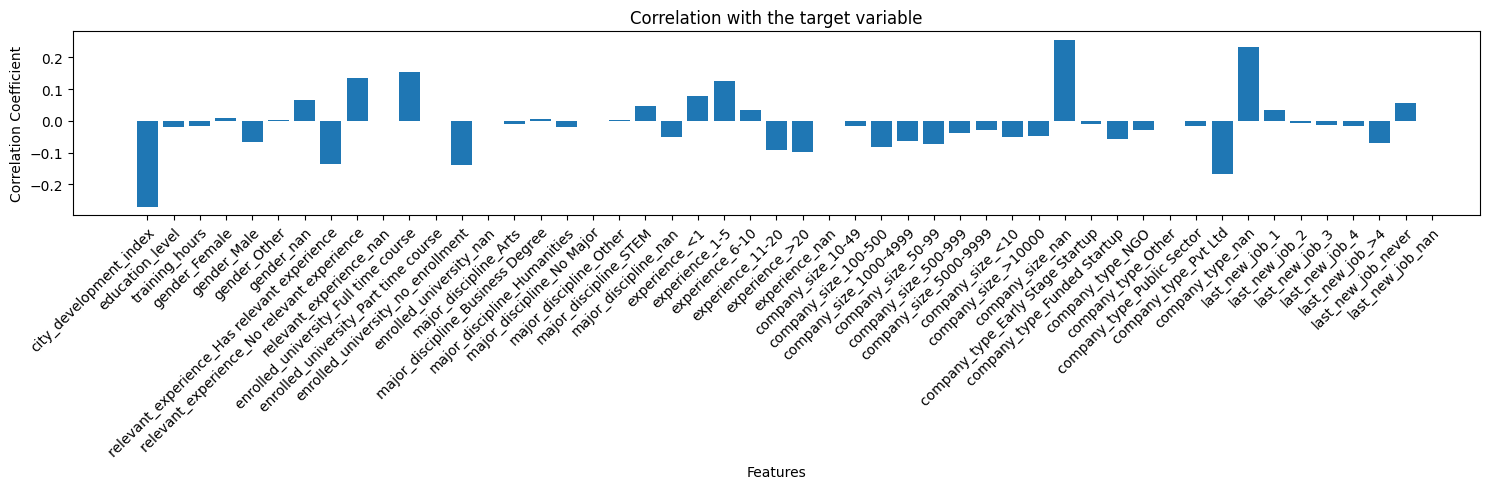

In [12]:
# Calculate the correlation matrix (leaving out the enrollee_id column)
correlation_matrix = ohe_churn_for_corr.loc[:, ~(ohe_churn_for_corr.columns.isin(['enrollee_id']))].corr('spearman')

# Extract correlations between the target variable and other variables
target_correlations = correlation_matrix['target'].drop('target')

# Create a bar plot to visualize the correlations
plt.figure(figsize=(15, 5))
plt.bar(target_correlations.index, target_correlations.values)
plt.title('Correlation with the target variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.show()

Missing values handling strategies:
- Drop ```gender```  and ```major_discipline``` since they have almost no correlation with the target variable and contain a great number of NaNs.
- Impute with kNN imputer the NaNs in ```company_size``` and ```company_type```
- Drop the few lines with NaNs in ```enrolled_university```, ```education_level```,	```experience```, ```last_new_job``` (done before One Hot Encoding)

In [13]:
# Reproduce the One-Hot-Encoded dataframe leaving out company_size and company_type
ohe_churn = pd.get_dummies(churn, columns=['gender', 'relevant_experience', 'enrolled_university', 'major_discipline', 'experience', 'last_new_job'], dtype=int, dummy_na=True)

In [14]:
# Drop gender and major_discipline
ohe_churn.drop(['gender_Female','gender_Male','gender_Other','gender_nan','major_discipline_Arts', 'major_discipline_Business Degree',
       'major_discipline_Humanities', 'major_discipline_No Major',
       'major_discipline_Other', 'major_discipline_STEM',
       'major_discipline_nan'], axis=1, inplace=True)

In [15]:
# knn_imputer = KNNImputer(n_neighbors=3)
# # Impute company_size
# pd.DataFrame(knn_imputer.fit_transform(ohe_churn.drop(['target','company_type'], axis=1)), columns=ohe_churn.drop(['target','company_type'], axis=1).columns)
# # Impute company_type
# pd.DataFrame(knn_imputer.fit_transform(ohe_churn.drop(['target','company_size'], axis=1)), columns=ohe_churn.drop(['target','company_size'], axis=1).columns)

❌ No implementation for imputing NaNs of a categorical variable with kNN, so I'll use "Most frequent" imputation

In [16]:
# Initate the imputer class
simple_imputer = SimpleImputer(missing_values=pd.NA, strategy='most_frequent')
# Imputwe the NaNs with the most frequent value
df_imputed = pd.DataFrame(simple_imputer.fit_transform(ohe_churn.drop('target', axis=1)), columns=ohe_churn.drop('target', axis=1).columns)
# Attach back the target column
ohe_churn = pd.concat((df_imputed, ohe_churn.target), axis=1)
ohe_churn.head()

,enrollee_id,city_development_index,education_level,company_size,company_type,training_hours,relevant_experience_Has relevant experience,relevant_experience_No relevant experience,relevant_experience_nan,enrolled_university_Full time course,...,experience_>20,experience_nan,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never,last_new_job_nan,target
0,8949,0.92,3.0,50-99,Pvt Ltd,36,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1.0
1,29725,0.776,3.0,50-99,Pvt Ltd,47,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.0
2,11561,0.624,3.0,50-99,Pvt Ltd,83,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0.0
3,666,0.767,4.0,50-99,Funded Startup,8,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0.0
4,21651,0.764,3.0,50-99,Pvt Ltd,24,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1.0


In [17]:
# Check for further NaNs --> Sum should be zero
print(ohe_churn.isna().sum())
# Check for 1 in the dummies variables for the NaNs --> Sum should be zero
print(ohe_churn.loc[ : , ohe_churn.columns.isin(['relevant_experience_nan','enrolled_university_nan','experience_nan','last_new_job_nan',])].sum())

enrollee_id                                    0
city_development_index                         0
education_level                                0
company_size                                   0
company_type                                   0
training_hours                                 0
relevant_experience_Has relevant experience    0
relevant_experience_No relevant experience     0
relevant_experience_nan                        0
enrolled_university_Full time course           0
enrolled_university_Part time course           0
enrolled_university_no_enrollment              0
enrolled_university_nan                        0
experience_<1                                  0
experience_1-5                                 0
experience_6-10                                0
experience_11-20                               0
experience_>20                                 0
experience_nan                                 0
last_new_job_1                                 0
last_new_job_2      

# Model selection

Dataset preparation

In [18]:
# Get the dataframe without NaNs and all the dummies
ohe_churn = pd.get_dummies(ohe_churn, columns=['company_size', 'company_type'], dtype=int, dummy_na=False)
# Drop the NaNs dummies
ohe_churn = ohe_churn.drop(['relevant_experience_nan', 'enrolled_university_nan', 'experience_nan','last_new_job_nan'], axis=1)
# Drop one dummy per category to avoid the dummy trap plus the enrolle_id column
ohe_churn = ohe_churn.drop(['enrollee_id', 'relevant_experience_Has relevant experience', 'enrolled_university_Part time course', 'experience_<1','last_new_job_never','company_size_<10', 'company_type_Other'], axis=1)
X = ohe_churn.drop('target', axis=1).astype(float)
y = ohe_churn.target.astype(int)

Logistic regression

In [19]:
logreg_model = LogisticRegression(penalty='l2', max_iter = 10000)

cv_scores = cross_val_score(logreg_model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print(f"Mean Accuracy: {cv_scores.mean()}")

Cross-Validation Scores: [0.77213433 0.77268943 0.76797114 0.77046905 0.7759578 ]
Mean Accuracy: 0.7718443495865236


XGBoost

In [20]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", seed=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.78018318 0.77740772 0.7743547  0.77629753 0.77512493]
Mean Accuracy: 0.7766736122637022


Kernel SVM

In [21]:
svm_model = SVC(kernel='rbf',degree=3,gamma='scale',max_iter=100000000)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_model, X_scaled, y, cv=cv, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.77324452 0.76935887 0.77102415 0.77463225 0.76901721]
Mean Accuracy: 0.7714553992346744


#### Logistic regression
is the best model in terms of tradeoff between performance (second best accuracy: 0.7718 vs 0.7767) and interpretability because it is easy to link variables to a smaller/greater and positive/negative effect on the churn probability thanks to its coefficients.

Variables interpretation using statsmodel implementation

In [56]:
# Fit a logistic regression model with statsmodels
X_with_intercept = sm.add_constant(X)
sm_logreg_model = sm.Logit(y, X_with_intercept)
logreg_result = sm_logreg_model.fit()

# Print statsmodels summary
print(logreg_result.summary())

Optimization terminated successfully.
         Current function value: 0.480625
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                18014
Model:                          Logit   Df Residuals:                    17986
Method:                           MLE   Df Model:                           27
Date:                Sat, 06 Jan 2024   Pseudo R-squ.:                  0.1375
Time:                        16:00:05   Log-Likelihood:                -8658.0
converged:                       True   LL-Null:                       -10038.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       

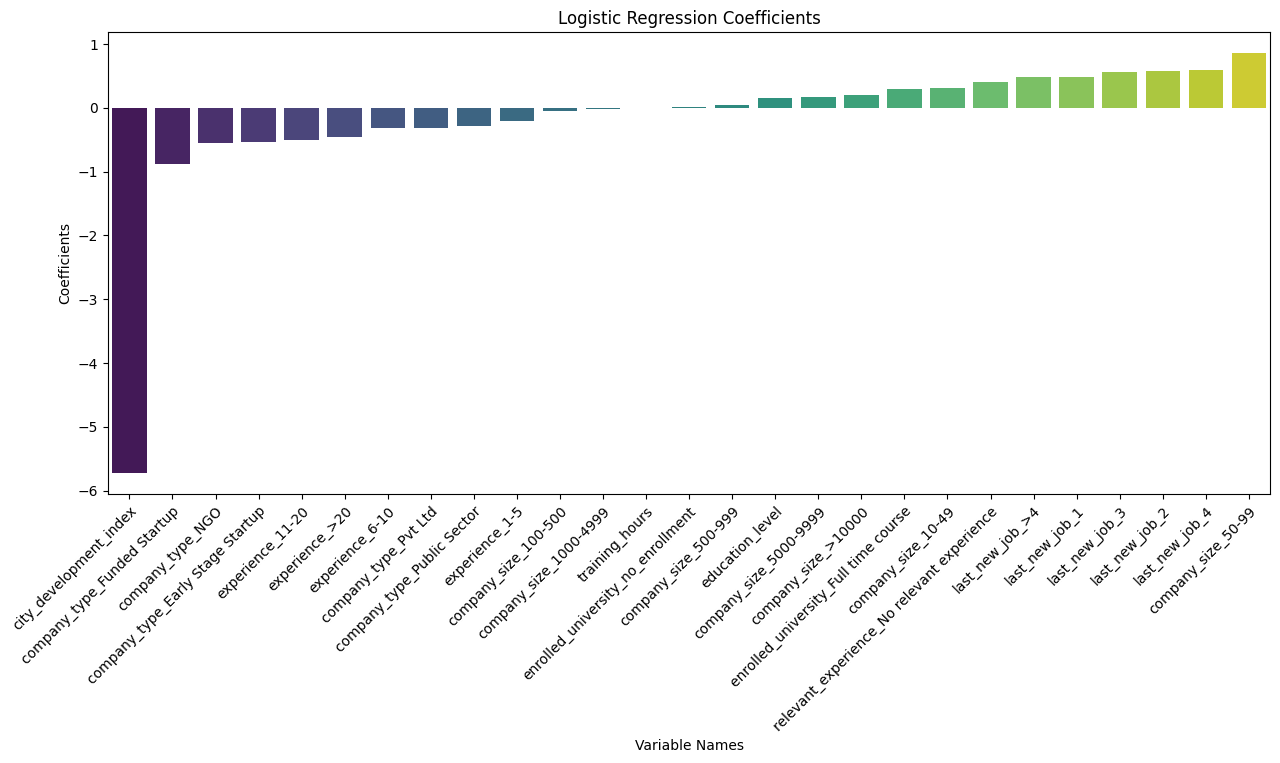

In [67]:
# Get variable names and corresponding coefficients
coefficients = logreg_result.params[1:]  # Exclude the intercept
sorted_variable_names = list(coefficients.sort_values().index)
sorted_coefficients = coefficients[sorted_variable_names]

# Plot bar chart
plt.figure(figsize=(15, 6))
sns.barplot(x=sorted_variable_names, y=sorted_coefficients, hue=sorted_variable_names, palette="viridis", legend=False)
plt.title("Logistic Regression Coefficients")
plt.xlabel("Variable Names")
plt.ylabel("Coefficients")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

In [58]:
predictions = pd.Series(sm_logreg_model.predict(params = logreg_result.params, exog = X_with_intercept), name='churn_probability')

In [59]:
churn_probabilities = pd.concat((ohe_churn.enrollee_id, predictions), axis=1)
churn_probabilities

,enrollee_id,churn_probability
0,8949,0.170609
1,29725,0.397929
2,11561,0.600953
3,666,0.275130
4,21651,0.325203
...,...,...
18009,7386,0.270826
18010,31398,0.178185
18011,24576,0.185503
18012,5756,0.199120


In [60]:
# Get the employees most likely to churn
churn_probabilities[churn_probabilities.churn_probability > 0.75]

,enrollee_id,churn_probability
67,29117,0.773096
128,30488,0.817018
277,18161,0.799689
405,18454,0.787496
528,28477,0.768054
...,...,...
17262,29352,0.759847
17543,23320,0.763713
17789,32400,0.842723
17836,14702,0.781612


In [61]:
logreg_result.save(r"C:\Users\leoac\OneDrive\Work\Applications\xTream\xtream-ai-assignment\logreg_fit.pickle")

In [64]:
loaded = sm.load(r"C:\Users\leoac\OneDrive\Work\Applications\xTream\xtream-ai-assignment\logreg_fit.pickle")

In [66]:
loaded.predict(exog = X_with_intercept)

0        0.170609
1        0.397929
2        0.600953
3        0.275130
4        0.325203
           ...   
18009    0.270826
18010    0.178185
18011    0.185503
18012    0.199120
18013    0.275800
Length: 18014, dtype: float64